In [1]:
# %reset -f

import datetime
import gurobipy as gp
import itertools
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import pickle
import requests
import re
import scipy as sci
import sympy as sym
import warnings

from bs4 import BeautifulSoup
from gurobipy import GRB
from matplotlib.ticker import MultipleLocator
from numpy import sqrt, exp, log, sin, cos, pi
from numba import jit

# 全局绘图样式设置

# 整体风格
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
# 字体
plt.rcParams['font.family'] = 'Times New Roman + Microsoft YaHei'
plt.rcParams['font.size'] = 13
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
# 取消右侧和上方的刻度线
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# 网格设置
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['axes.unicode_minus'] = False
# 主副刻度线
plt.rcParams['axes.linewidth'] = 1.3  # 主刻度线的粗细

plt.rcParams['xtick.major.width'] = 1.3  # x:主刻度:宽度
plt.rcParams['xtick.major.size'] = 5.3     # x:主刻度:长度
plt.rcParams['xtick.minor.width'] = 1.3  # x:副刻度:宽度
plt.rcParams['xtick.minor.size'] = 3     # x:副刻度:长度

plt.rcParams['ytick.major.width'] = 1.3  # y:主刻度:宽度
plt.rcParams['ytick.major.size'] = 5.3     # y:主刻度:长度
plt.rcParams['ytick.minor.width'] = 1.3  # y:副刻度:宽度
plt.rcParams['ytick.minor.size'] = 3     # y:副刻度:长度
# 设置使用latex
plt.rcParams['text.usetex'] = False

warnings.filterwarnings('ignore')

# %matplotlib inline
# matplotlib.use('TkAgg')


In [144]:
import scipy.io as sio

# 读取MATLAB文件
mat_file = sio.loadmat('data2py/q3_data.mat')
# # 获取所有变量名
var_names = mat_file.keys()
# # 获取指定变量的值


In [105]:
var_names

dict_keys(['__header__', '__version__', '__globals__', 'P_1231', 'Pt', 'X', 'Y', 'Z', 'inter_data', 'inter_time', 'prob_recoder', 't', 'xyz_v'])

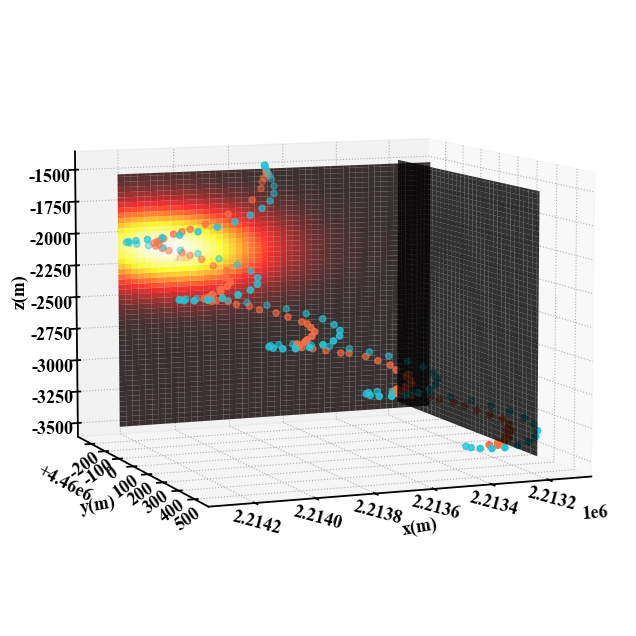

In [221]:
# 绘制三维热力图
%matplotlib inline
# matplotlib.use('TkAgg')
# 描点
t = mat_file['t']
xyz_v = mat_file['xyz_v']
Pt = mat_file['Pt']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(xyz_v[:, 0], xyz_v[:, 1], xyz_v[:, 2],c='#26C6DA')
ax.scatter(Pt[:, 0], Pt[:, 1], Pt[:, 2],c='#FF7043')
ax.set_xlabel('x(m)', rotation=10, labelpad=1)
ax.xaxis.set_tick_params(labelrotation=-15, pad=-5)
ax.set_ylabel('y(m)', labelpad=4, rotation=10)
ax.yaxis.set_tick_params(labelrotation=35, pad=-4)
ax.set_zlabel('z(m)', labelpad=6, rotation=90)
ax.zaxis.set_tick_params(labelrotation=0, pad=4)
ax.view_init(elev=8, azim=68)

# 绘制属于y的第四个平面信息
idx_1 = 11
# 获取平面上的gird信息
X = mat_file['X']
Y = mat_file['Y']
Z = mat_file['Z']
P = mat_file['P_1231']
y_plane = 4.459868166746858e+06 - 30
X_1 = X[idx_1, :, :]
Z_1 = Z[idx_1, :, :]
P_1 = P[idx_1, :, :]

# 归一化P_500
P_1_min = P_1.min()
P_1_max = P_1.max()
P_1_normalized = (P_1 - P_1_min) / (P_1_max - P_1_min)

ax.plot_surface(X_1, y_plane, Z_1, facecolors=plt.cm.hot(P_1_normalized), linewidth=0, alpha=0.8, shade=False)

# 再画一个面
idx_2 = 4
x_plane = 2.213202134063654e+06
Y_2 = Y[:, idx_2, :]
Z_2 = Z[:, idx_2, :]
P_2 = P[:, idx_2, :]
P_2_min = P_2.min()
P_2_max = P_2.max()
P_2_normalized = (P_2 - P_2_min) / (P_2_max - P_2_min)
ax.plot_surface(x_plane, Y_2, Z_2, color='black', linewidth=0, alpha=0.8, shade=False)
ax.scatter(Pt[31, 0], Pt[31, 1], Pt[31, 2],marker='^',s=100,c='#EF5350')


# plt.pause(1000)
# im = ax.plot_surface(X, y_plane * np.ones_like(X), Z, , shade=False)
# ax.set_xlim()
# ax.set_ylim()
# ax.set_xlabel('-Xlabel-')
# ax.set_ylabel('-Ylabel-')
# 名字，去白边，背景透明
# plt.savefig('带缩放的曲线图.svg', bbox_inches='tight', transparent=True)

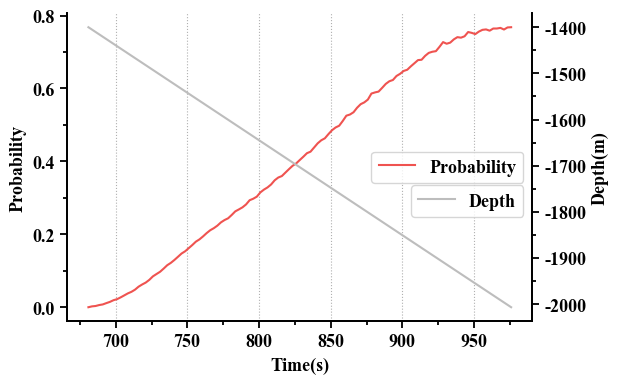

In [269]:
%matplotlib inline
plt.rcParams['axes.spines.right'] = True
prob_recoder = mat_file['prob_recoder']

fig, ax = plt.subplots(figsize=(6,4))
p = prob_recoder[:, 2]
# 获取p的最小值和最大值
p_min = p.min()
p_max = p.max()
# 将p归一化到0和1之间，然后乘以0.768
p_scaled = 0.768 * (p - p_min) / (p_max - p_min)
ax.plot(prob_recoder[:, 0], p_scaled,color='#EF5350')
ax.set_xlim()
ax.set_ylim()
ax.set_xlabel('Time(s)')
ax.set_ylabel('Probability')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.yaxis.grid(False)
ax.legend(['Probability'], loc=5)
# 
ax2 = ax.twinx()
ax2.plot(prob_recoder[:, 0], prob_recoder[:, 1],color='#BDBDBD')
ax2.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax2.set_ylabel('Depth(m)')
ax2.yaxis.grid(False)
ax2.legend(['Depth'], bbox_to_anchor=(1, 0.47))
# # 文本框
# bbox = {"facecolor": "#EF5350", "alpha": 0.5}
# styles = {"size": 13, "color": "black", "bbox": bbox}
# ax.text(10, 0.55 * 1e12, "Number of grids < Number of planned electric fields", **styles)
# # 箭头xytext:起点坐标, xy:终点坐标
# ax.annotate('', xytext=(9, 0.555 * 1e12), xy=(2.3, 0.52 * 1e12), arrowprops=dict(facecolor='black', shrink=0.05))
# 
# # 缩放图的位置[左下角x, 左下角y, xlen, ylen]
# axin_size = [0.7, -0.8, 1.5, 1]
# # 缩放内容区间
# xlim = [1, 2.5]
# ylim = [0.5, 1.05]
# loc = [0, 0, 1, 2]
# # loc[0]=0：不连接
# # loc[0]=3：原图框选区域的左上角坐标与axins的左下角连接
# # loc[3]=1：原图框选区域的右下角坐标与axins的左上角连接
# # 左上，右上，左下，右下
# 
# # 调用函数绘制连线
# my_zoom(x, y, ax, axin_size, xlim, ylim, loc)

# 名字，去白边，背景透明
plt.savefig('fig/深度概率图.pdf', bbox_inches='tight', transparent=False)